In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from pyod.models.knn import KNN 

from sklearn.feature_selection import( 
    RFECV,
    SequentialFeatureSelector,
    SelectFromModel
)

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import(
    RandomForestClassifier,
    HistGradientBoostingClassifier
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from src.wrapped import Wrapped
from src.analyses import graphic_anomalies
from src.train import cross_validate_balancead, train_feature_combination

In [2]:
wp = Wrapped(
    '../data/row/',
    '../data/processed/',
    '../data/files/'
)

# Importando dados para treinamento

In [6]:
df = wp.load_data('df_instrumentos_features_selecionadas')
#instrumentos de percusão:
inst_percusao = ["mallet_percussion", "drums", "cymbals"]

df = df[df['instrumento'].isin(inst_percusao)]

- Definindo as variaveis de treino e o target

In [7]:
le = LabelEncoder()
df['labels'] = le.fit_transform(df.instrumento)

In [8]:
X = df.drop(columns=['labels', 'instrumento','file_name'])
y = df['labels'].to_frame()

# TESTE 1: Balanceamento

- 1° Opção: Balanceamento das classes com SMOTH

In [ ]:
t1_models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    MLPClassifier(),
    SVC(),
])

t1_acuracy_models = [cross_validate_balancead(k=5, model=model, X=X, y=y, oversampling=True) for model in t1_models]

dict_results_t1 = {
    'Naive Bayes': t1_acuracy_models[0],
    'KNN': t1_acuracy_models[1],
    'Arvore de Decisão': t1_acuracy_models[2],
    'Floresta Aleatoria': t1_acuracy_models[3],
    'HistGradientBoosting': t1_acuracy_models[4],
    'LIGHTGBM': t1_acuracy_models[5],
    'MLP': t1_acuracy_models[6],
    'SVC': t1_acuracy_models[7],
}

dict_results_t1

- 2° Opção: Class Weight

In [7]:
models_class_weight = np.array([
    DecisionTreeClassifier(class_weight='balanced'), 
    RandomForestClassifier(class_weight='balanced', random_state = 0, n_jobs = -1), 
    LGBMClassifier(class_weight='balanced'),
])

t1_acuracy_models_class_weight = [cross_validate_balancead(k=5, model=model, X=X, y=y, weight=True) for model in models_class_weight]

dict_results_t1_class_weight = {
    'Arvore de Decisão': t1_acuracy_models_class_weight[0],
    'Floresta Aleatoria': t1_acuracy_models_class_weight[1],
    'LIGHTGBM': t1_acuracy_models_class_weight[2],
}

dict_results_t1_class_weight

Acuracia do modelo DecisionTreeClassifier(class_weight='balanced') do Fold 0: 0.6057692307692307
Acuracia do modelo DecisionTreeClassifier(class_weight='balanced') do Fold 1: 0.5608974358974359
Acuracia do modelo DecisionTreeClassifier(class_weight='balanced') do Fold 2: 0.6538461538461539
Acuracia do modelo DecisionTreeClassifier(class_weight='balanced') do Fold 3: 0.684887459807074
Acuracia do modelo DecisionTreeClassifier(class_weight='balanced') do Fold 4: 0.6205787781350482
Acuracia do modelo RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0) do Fold 0: 0.7051282051282052
Acuracia do modelo RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0) do Fold 1: 0.7115384615384616
Acuracia do modelo RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0) do Fold 2: 0.717948717948718
Acuracia do modelo RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0) do Fold 3: 0.797427652733119
Acuracia do modelo Ran

{'Arvore de Decisão': 0.6251958116909885,
 'Floresta Aleatoria': 0.7362478357655207,
 'LIGHTGBM': 0.7631770962156814}

# TESTE 2: Remover Outlier

- Treinar modelo de classificação de outilier

In [10]:
detector_outilier = KNN()

new_df = df.drop(columns=['instrumento','file_name'])

detector_outilier.fit(new_df)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

- Checar numeros de outilers e não outilers<br/>
**0 (False) Não é outiler**<br/>
**1 (True) É outiler**

In [11]:
previsions = detector_outilier.labels_
np.unique(previsions, return_counts=True)

(array([0, 1]), array([1402,  156]))

- Distancia euclidiana dos registros

In [12]:
confiance_previsions = detector_outilier.decision_scores_
confiance_previsions

array([ 613.95926941, 1319.66634087,  507.03578932, ...,  873.70575534,
        515.88948026, 1031.280418  ])

- Checar os outilers

In [13]:
# pegando indice dos registros que são outilers
outilers_id =[previsions[i] == 1 for i in range(previsions.shape[0])]
outilers = df.iloc[outilers_id,:]
outilers

tonnetz0  tonnetz1   chroma1   chroma2   chroma3   chroma4   chroma5  \
2028  0.064332 -0.023445  0.221986  0.318158  0.420399  0.800723  0.699277   
2066  0.067263 -0.079658  0.400289  0.414243  0.519233  0.403937  0.590723   
2080 -0.028268  0.020594  0.308341  0.539134  0.486185  0.370537  0.365475   
2087  0.000423  0.008728  0.315313  0.329236  0.318093  0.291647  0.358462   
2090 -0.027502 -0.040906  0.428343  0.575150  0.432707  0.349952  0.269307   
...        ...       ...       ...       ...       ...       ...       ...   
4548 -0.336018 -0.463490  0.187934  0.705260  0.531249  0.322856  0.199759   
4549  0.002682 -0.031066  0.318778  0.249719  0.236765  0.188140  0.255103   
4573  0.424326 -0.240209  0.127338  0.211656  0.438093  0.604280  0.843284   
4577  0.348110  0.159918  0.278293  0.092337  0.303201  0.065521  0.185706   
4581  0.064085  0.031877  0.088719  0.110646  0.159631  0.303337  0.233713   

       chroma6   chroma7       mfcc0  ...  spectral_centroid  spectral_onset  \
2028  0.292424  0.310495  -92.665298  ...        2549.517812        1.755609   
2066  0.326989  0.475230  -97.677353  ...        3813.025950        1.273033   
2080  0.277279  0.237507 -201.765625  ...        5631.779972        1.150056   
2087  0.355331  0.340839 -375.171051  ...        4034.598255        2.311115   
2090  0.282274  0.353393 -208.308487  ...        4320.618296        1.748420   
...        ...       ...         ...  ...                ...             ...   
4548  0.178082  0.259735 -298.939850  ...        1251.895828        0.913958   
4549  0.378614  0.406869 -389.299408  ...        3257.742889        1.764614   
4573  0.976121  0.586622 -423.657928  ...         283.995303        0.419410   
4577  0.234855  0.103411 -222.538467  ...        2264.087534        1.359796   
4581  0.293759  0.225420 -306.869537  ...        1950.192940        1.101535   

      spectral_rolloff  spectogram  mel_spectogram  zero_crossing_rate  \
2028       4183.087002  -47.144733      -65.961197            0.182486   
2066       7134.060110  -47.323631      -62.697948            0.257473   
2080       8727.017531  -66.101967      -79.368797            0.486816   
2087       7370.300831  -48.193481      -79.993744            0.275738   
2090       7560.852192  -42.228710      -69.745705            0.315267   
...                ...         ...             ...                 ...   
4548       2349.167543  -39.887836      -76.786873            0.104538   
4549       5858.005490  -69.019249      -74.674164            0.244661   
4573        510.951435  -62.118206      -73.764893            0.012129   
4577       3551.354782  -21.233885      -59.256969            0.166638   
4581       2585.158459  -50.985691      -72.046715            0.160147   

      zero_crossing        instrumento          file_name  labels  
2028          40358            cymbals   000776_42240.ogg       0  
2066          56977            cymbals   014557_15360.ogg       0  
2080         107670            cymbals   016284_53760.ogg       0  
2087          60975            cymbals   019866_65280.ogg       0  
2090          69716            cymbals  019924_249600.ogg       0  
...             ...                ...                ...     ...  
4548          23109  mallet_percussion   145921_42240.ogg       2  
4549          54124  mallet_percussion    146059_7680.ogg       2  
4573           2688  mallet_percussion  150751_268800.ogg       2  
4577          36868  mallet_percussion   152214_23040.ogg       2  
4581          35457  mallet_percussion  154224_203520.ogg       2  

[156 rows x 47 columns]

- Visualização de outilers

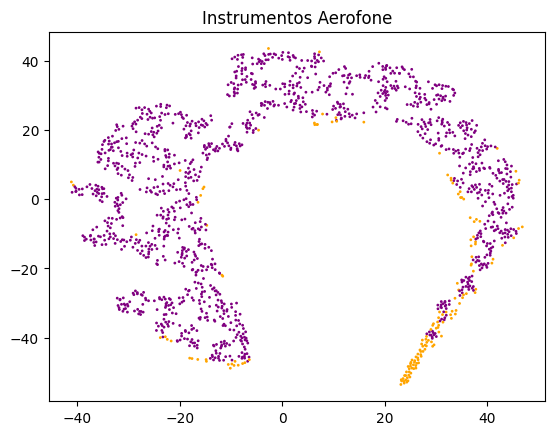

In [18]:
graphic_anomalies(df.drop(columns=['instrumento','file_name']), 'Instrumentos Aerofone')

In [19]:
outilers.instrumento.value_counts()

mallet_percussion    86
cymbals              42
drums                28
Name: instrumento, dtype: int64

- Agora vamos remover os outilers da nossa base

In [20]:
# pegando indice dos registros que não são outilers
outilers_id =[previsions[i] == 0 for i in range(previsions.shape[0])]
df_train = df.iloc[outilers_id,:]
df_train

tonnetz0  tonnetz1   chroma1   chroma2   chroma3   chroma4   chroma5  \
2027  0.040087  0.116203  0.409334  0.260820  0.298635  0.223068  0.472596   
2029 -0.039875  0.021506  0.597219  0.522248  0.357256  0.306705  0.454092   
2030 -0.039822  0.028304  0.621655  0.511336  0.348413  0.316168  0.392748   
2031  0.098013  0.027428  0.383891  0.186740  0.131834  0.186899  0.345623   
2032 -0.303404 -0.130108  0.085408  0.186222  0.155259  0.141001  0.098264   
...        ...       ...       ...       ...       ...       ...       ...   
4580  0.113357  0.063352  0.217164  0.143870  0.322778  0.112114  0.120639   
4582  0.264473 -0.245898  0.214395  0.094173  0.177360  0.087018  0.063969   
4583  0.087865 -0.048417  0.321572  0.221088  0.240128  0.374176  0.547956   
4584  0.432549  0.102409  0.204631  0.283638  0.785254  0.440283  0.356656   
4585  0.014791 -0.048288  0.541724  0.773484  0.336424  0.227664  0.204356   

       chroma6   chroma7       mfcc0  ...  spectral_centroid  spectral_onset  \
2027  0.682380  0.315802 -324.986115  ...        2843.107702        0.915473   
2029  0.676822  0.459109 -167.831787  ...        2543.370274        0.869033   
2030  0.568508  0.565586 -389.340240  ...        2479.813426        1.396642   
2031  0.210410  0.242533 -169.979294  ...        2037.566496        1.731518   
2032  0.192068  0.148555 -181.919373  ...        2076.334809        0.991361   
...        ...       ...         ...  ...                ...             ...   
4580  0.256409  0.116839 -342.947083  ...        1661.007320        1.292728   
4582  0.138096  0.353633 -242.346970  ...        1984.641346        1.996110   
4583  0.418325  0.338949  -51.251186  ...        3307.151107        1.378473   
4584  0.148266  0.208002 -166.508652  ...        1533.762409        1.141370   
4585  0.160793  0.189487 -569.040527  ...        2654.730407        0.888146   

      spectral_rolloff  spectogram  mel_spectogram  zero_crossing_rate  \
2027       6288.444728  -72.321693      -79.942192            0.106036   
2029       4545.004690  -59.076328      -70.129898            0.152626   
2030       5702.476809  -63.114140      -71.209488            0.082574   
2031       4412.483063  -56.386051      -59.750889            0.079232   
2032       4868.577289  -60.910480      -69.440315            0.055700   
...                ...         ...             ...                 ...   
4580       3554.577269  -43.292679      -54.901520            0.055292   
4582       4595.240504  -66.942772      -78.150574            0.064426   
4583       6980.305045  -56.667892      -75.132233            0.158234   
4584       2913.027706  -68.506294      -79.922241            0.079375   
4585       4855.912168  -69.034531      -79.096352            0.179663   

      zero_crossing        instrumento          file_name  labels  
2027          23418            cymbals  000385_249600.ogg       0  
2029          33743            cymbals  001175_161280.ogg       0  
2030          18250            cymbals    003456_7680.ogg       0  
2031          17508            cymbals   003533_72960.ogg       0  
2032          12310            cymbals  004072_130560.ogg       0  
...             ...                ...                ...     ...  
4580          12232  mallet_percussion  153985_115200.ogg       2  
4582          14272  mallet_percussion       154500_0.ogg       2  
4583          35032  mallet_percussion   154708_11520.ogg       2  
4584          17537  mallet_percussion  154943_188160.ogg       2  
4585          39717  mallet_percussion   155007_46080.ogg       2  

[1402 rows x 47 columns]

- Treinar modelos sem outlier e balanceameto

In [14]:
X_rm_outilers = df_train.drop(columns=['labels', 'instrumento','file_name'])
y_rm_outilers = df_train['labels'].to_frame()

models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    MLPClassifier(),
    SVC(),
])

t2_acuracy_models = [cross_validate_balancead(k=5, model=model, X=X_rm_outilers,  y=y_rm_outilers) for model in models]

dict_results_t2 = {
    'Naive Bayes': t2_acuracy_models[0],
    'KNN': t2_acuracy_models[1],
    'Arvore de Decisão': t2_acuracy_models[2],
    'Floresta Aleatoria': t2_acuracy_models[3],
    'HistGradientBoosting': t2_acuracy_models[4],
    'LIGHTGBM': t2_acuracy_models[5],
    'MLP': t2_acuracy_models[6],
    'SVC': t2_acuracy_models[7],
}

dict_results_t2

Acuracia do modelo GaussianNB() do Fold 0: 0.6832740213523132
Acuracia do modelo GaussianNB() do Fold 1: 0.6654804270462633
Acuracia do modelo GaussianNB() do Fold 2: 0.6571428571428571
Acuracia do modelo GaussianNB() do Fold 3: 0.7071428571428572
Acuracia do modelo GaussianNB() do Fold 4: 0.6857142857142857
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.5480427046263345
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.5302491103202847
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.5071428571428571
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.5607142857142857
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.5571428571428572
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.6192170818505338
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.5871886120996441
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.6535714285714286
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.65
Acuracia do modelo DecisionTreeClassifier() do F

{'Naive Bayes': 0.6797508896797153,
 'KNN': 0.5406583629893238,
 'Arvore de Decisão': 0.6291382816471784,
 'Floresta Aleatoria': 0.7403838332486019,
 'HistGradientBoosting': 0.7468327402135231,
 'LIGHTGBM': 0.7439883070665989,
 'MLP': 0.46872394509405185,
 'SVC': 0.5706354855109304}

# TESTE 3: Features de Maior Correlação

In [15]:
df_corr = df.drop(columns=['instrumento', 'file_name', 'labels']).corr().unstack().reset_index().dropna()
df_corr.rename(columns = {'level_0': 'features_a', 'level_1': 'features_b', 0:'correlacao'}, inplace = True)
df_corr

features_a          features_b  correlacao
0          tonnetz0            tonnetz0    1.000000
1          tonnetz0            tonnetz1    0.097524
2          tonnetz0             chroma1   -0.107305
3          tonnetz0             chroma2   -0.203962
4          tonnetz0             chroma3    0.074164
...             ...                 ...         ...
1931  zero_crossing    spectral_rolloff    0.691660
1932  zero_crossing          spectogram   -0.016326
1933  zero_crossing      mel_spectogram   -0.064879
1934  zero_crossing  zero_crossing_rate    0.999999
1935  zero_crossing       zero_crossing    1.000000

[1936 rows x 3 columns]

- Correlação Positia

In [16]:
corr_posit = df_corr.query('correlacao > 0.5 and correlacao < 1.0')
corr_posit

features_a          features_b  correlacao
91               chroma1             chroma2    0.588773
121              chroma1            chroma12    0.588875
134              chroma2             chroma1    0.588773
136              chroma2             chroma3    0.612664
179              chroma3             chroma2    0.612664
...                  ...                 ...         ...
1887  zero_crossing_rate    spectral_rolloff    0.691649
1891  zero_crossing_rate       zero_crossing    0.999999
1929       zero_crossing   spectral_centroid    0.855792
1931       zero_crossing    spectral_rolloff    0.691660
1934       zero_crossing  zero_crossing_rate    0.999999

[82 rows x 3 columns]

In [17]:
len(corr_posit.features_a.unique()), corr_posit.features_a.unique()

(32,
 array(['chroma1', 'chroma2', 'chroma3', 'chroma4', 'chroma5', 'chroma6',
        'chroma7', 'mfcc0', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10',
        'mfcc11', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'chroma8',
        'chroma9', 'chroma10', 'chroma11', 'chroma12', 'spectral_band2',
        'spectral_band3', 'spectral_band4', 'spectral_centroid',
        'spectral_rolloff', 'spectogram', 'mel_spectogram',
        'zero_crossing_rate', 'zero_crossing'], dtype=object))

In [18]:
X =  df[corr_posit.features_a.unique()]
y = df['labels'].to_frame()

models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t3_acuracy_models_corr_posit = [cross_validate_balancead(k=5, model=model, X=X, y=y) for model in models]

dict_results_t3_corr_posit = {
    'Naive Bayes': t3_acuracy_models_corr_posit[0],
    'KNN': t3_acuracy_models_corr_posit[1],
    'Arvore de Decisão': t3_acuracy_models_corr_posit[2],
    'Floresta Aleatoria': t3_acuracy_models_corr_posit[3],
    'HistGradientBoosting': t3_acuracy_models_corr_posit[4],
    'LIGHTGBM': t3_acuracy_models_corr_posit[5],
    'XGB': t3_acuracy_models_corr_posit[6],
    'MLP': t3_acuracy_models_corr_posit[7],
    'SVC': t3_acuracy_models_corr_posit[8],
}

dict_results_t3_corr_posit

Acuracia do modelo GaussianNB() do Fold 0: 0.6314102564102564
Acuracia do modelo GaussianNB() do Fold 1: 0.6506410256410257
Acuracia do modelo GaussianNB() do Fold 2: 0.6538461538461539
Acuracia do modelo GaussianNB() do Fold 3: 0.6881028938906752
Acuracia do modelo GaussianNB() do Fold 4: 0.6945337620578779
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.5673076923076923
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.5352564102564102
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.5032051282051282
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.5530546623794212
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.5562700964630225
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.5480769230769231
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.6089743589743589
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.5993589743589743
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.6463022508038585
Acuracia do modelo DecisionTreeCla

{'Naive Bayes': 0.6637068183691979,
 'KNN': 0.5430187979223349,
 'Arvore de Decisão': 0.6046582570698327,
 'Floresta Aleatoria': 0.7233902217825048,
 'HistGradientBoosting': 0.7317441668727842,
 'LIGHTGBM': 0.726605655866106,
 'XGB': 0.724033308599225,
 'MLP': 0.49679899414626105,
 'SVC': 0.5616209085662461}

- Correlação Negativa

In [19]:
corr_negat = df_corr.query('correlacao > -1.0 and correlacao < -0.5')
corr_negat

features_a          features_b  correlacao
474                mfcc1      spectral_band2   -0.785703
475                mfcc1      spectral_band3   -0.723600
476                mfcc1      spectral_band4   -0.630621
477                mfcc1   spectral_centroid   -0.884908
479                mfcc1    spectral_rolloff   -0.857500
482                mfcc1  zero_crossing_rate   -0.692533
483                mfcc1       zero_crossing   -0.692563
1506      spectral_band2               mfcc1   -0.785703
1550      spectral_band3               mfcc1   -0.723600
1594      spectral_band4               mfcc1   -0.630621
1638   spectral_centroid               mfcc1   -0.884908
1726    spectral_rolloff               mfcc1   -0.857500
1858  zero_crossing_rate               mfcc1   -0.692533
1902       zero_crossing               mfcc1   -0.692563

In [20]:
X =  df[corr_negat.features_b.unique()]
y = df['labels'].to_frame()

models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t3_acuracy_models_corr_neg = [cross_validate_balancead(k=5, model=model, X=X, y=y) for model in models]

dict_results_t3_corr_neg = {
    'Naive Bayes': t3_acuracy_models_corr_neg[0],
    'KNN': t3_acuracy_models_corr_neg[1],
    'Arvore de Decisão': t3_acuracy_models_corr_neg[2],
    'Floresta Aleatoria': t3_acuracy_models_corr_neg[3],
    'HistGradientBoosting': t3_acuracy_models_corr_neg[4],
    'LIGHTGBM': t3_acuracy_models_corr_neg[5],
    'XGB': t3_acuracy_models_corr_neg[6],
    'MLP': t3_acuracy_models_corr_neg[7],
    'SVC': t3_acuracy_models_corr_neg[8],
}

dict_results_t3_corr_neg

Acuracia do modelo GaussianNB() do Fold 0: 0.5192307692307693
Acuracia do modelo GaussianNB() do Fold 1: 0.5288461538461539
Acuracia do modelo GaussianNB() do Fold 2: 0.5641025641025641
Acuracia do modelo GaussianNB() do Fold 3: 0.5980707395498392
Acuracia do modelo GaussianNB() do Fold 4: 0.572347266881029
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.5608974358974359
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.5384615384615384
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.5096153846153846
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.5530546623794212
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.5530546623794212
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.46153846153846156
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.4775641025641026
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.5064102564102564
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.5112540192926045
Acuracia do modelo DecisionTreeCla

{'Naive Bayes': 0.5565194987220711,
 'KNN': 0.5430167367466403,
 'Arvore de Decisão': 0.4968196059032072,
 'Floresta Aleatoria': 0.5847122598730315,
 'HistGradientBoosting': 0.5821708302415698,
 'LIGHTGBM': 0.5988478027867095,
 'XGB': 0.5744723390221782,
 'MLP': 0.5031989446780443,
 'SVC': 0.5661204551075933}

- Se combinarmos as duas abordagens ?

In [21]:
features = np.append(corr_posit.features_b.unique(), corr_negat.features_b.unique())
features

array(['chroma2', 'chroma12', 'chroma1', 'chroma3', 'chroma4', 'chroma5',
       'chroma6', 'chroma7', 'chroma8', 'chroma9', 'spectral_band2',
       'spectral_band3', 'spectral_rolloff', 'mfcc7', 'mfcc6', 'mfcc8',
       'mfcc9', 'mfcc10', 'mfcc11', 'mfcc14', 'mfcc13', 'mfcc15',
       'mfcc16', 'chroma10', 'chroma11', 'mfcc0', 'spectral_band4',
       'spectral_centroid', 'zero_crossing_rate', 'zero_crossing',
       'mel_spectogram', 'spectogram', 'spectral_band2', 'spectral_band3',
       'spectral_band4', 'spectral_centroid', 'spectral_rolloff',
       'zero_crossing_rate', 'zero_crossing', 'mfcc1'], dtype=object)

In [22]:
len(np.unique(features))

33

In [23]:
features = np.unique(features)

X = df[features]
y = df['labels'].to_frame()

models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t3_combine_corr = [cross_validate_balancead(k=5, model=model, X=X, y=y) for model in models]

dict_results_t3_cb = {
    'Naive Bayes': t3_combine_corr[0],
    'KNN': t3_combine_corr[1],
    'Arvore de Decisão': t3_combine_corr[2],
    'Floresta Aleatoria': t3_combine_corr[3],
    'HistGradientBoosting': t3_combine_corr[4],
    'LIGHTGBM': t3_combine_corr[5],
    'XGB': t3_combine_corr[6],
    'MLP': t3_combine_corr[7],
    'SVC': t3_combine_corr[8],
}

dict_results_t3_cb

Acuracia do modelo GaussianNB() do Fold 0: 0.6314102564102564
Acuracia do modelo GaussianNB() do Fold 1: 0.6442307692307693
Acuracia do modelo GaussianNB() do Fold 2: 0.657051282051282
Acuracia do modelo GaussianNB() do Fold 3: 0.684887459807074
Acuracia do modelo GaussianNB() do Fold 4: 0.6977491961414791
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.5673076923076923
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.5352564102564102
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.5032051282051282
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.5530546623794212
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.5562700964630225
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.5705128205128205
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.5993589743589743
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.6089743589743589
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.6077170418006431
Acuracia do modelo DecisionTreeClass

{'Naive Bayes': 0.6630657927281721,
 'KNN': 0.5430187979223349,
 'Arvore de Decisão': 0.5994991343062083,
 'Floresta Aleatoria': 0.7221081705004535,
 'HistGradientBoosting': 0.7310948965289801,
 'LIGHTGBM': 0.7400795613818121,
 'XGB': 0.7375072141149311,
 'MLP': 0.523136697172067,
 'SVC': 0.5629070821996867}

- Correlação de -0.5 a 0.5

In [24]:
corr_prox_zero = df_corr.query('correlacao > -0.5 and correlacao < 0.5')
corr_prox_zero

features_a      features_b  correlacao
1          tonnetz0        tonnetz1    0.097524
2          tonnetz0         chroma1   -0.107305
3          tonnetz0         chroma2   -0.203962
4          tonnetz0         chroma3    0.074164
5          tonnetz0         chroma4   -0.228620
...             ...             ...         ...
1927  zero_crossing  spectral_band3    0.372231
1928  zero_crossing  spectral_band4    0.250646
1930  zero_crossing  spectral_onset    0.090096
1932  zero_crossing      spectogram   -0.016326
1933  zero_crossing  mel_spectogram   -0.064879

[1796 rows x 3 columns]

In [25]:
len(corr_prox_zero.features_b.unique())

44

In [26]:
X =  df[corr_prox_zero.features_b.unique()]
y = df['labels'].to_frame()

models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t3_acuracy_models_corr_prox_zero = [cross_validate_balancead(k=5, model=model, X=X, y=y) for model in models]

dict_results_t3_corr = {
    'Naive Bayes': t3_acuracy_models_corr_prox_zero[0],
    'KNN': t3_acuracy_models_corr_prox_zero[1],
    'Arvore de Decisão': t3_acuracy_models_corr_prox_zero[2],
    'Floresta Aleatoria': t3_acuracy_models_corr_prox_zero[3],
    'HistGradientBoosting': t3_acuracy_models_corr_prox_zero[4],
    'LIGHTGBM': t3_acuracy_models_corr_prox_zero[5],
    'XGB': t3_acuracy_models_corr_prox_zero[6],
    'MLP': t3_acuracy_models_corr_prox_zero[7],
    'SVC': t3_acuracy_models_corr_prox_zero[8],
}

dict_results_t3_corr

Acuracia do modelo GaussianNB() do Fold 0: 0.6730769230769231
Acuracia do modelo GaussianNB() do Fold 1: 0.657051282051282
Acuracia do modelo GaussianNB() do Fold 2: 0.6634615384615384
Acuracia do modelo GaussianNB() do Fold 3: 0.6977491961414791
Acuracia do modelo GaussianNB() do Fold 4: 0.6881028938906752
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.5673076923076923
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.5352564102564102
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.5064102564102564
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.5562700964630225
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.5562700964630225
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.5641025641025641
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.5993589743589743
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.625
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.6077170418006431
Acuracia do modelo DecisionTreeClassifier() do F

# TESTE4: Recursive Feature Elimination - (RFE)

- RFE

In [ ]:
X = df.drop(columns=['instrumento','file_name','labels'])
y = df['labels'].to_frame()

clf = DecisionTreeClassifier(max_depth=17,
                             max_features='auto', 
                             min_samples_leaf=2,
                             min_samples_split=3)
                               
                               
estimators = RFECV(estimator=clf, scoring='accuracy', cv=5)

# fit rfecv
rfecv_data = estimators.fit(X, y)

# gorresponde à posição do ranking do i-ésimo recurso
ranking_features = rfecv_data.ranking_

# A máscara dos recursos selecionados.
support_features = rfecv_data.support_

# filtro
features_selects = X.columns[support_features]

In [ ]:
features_selects

Index(['tonnetz1', 'chroma2', 'chroma3', 'chroma4', 'chroma5', 'chroma6',
       'chroma7', 'mfcc0', 'mfcc1', 'mfcc3', 'mfcc11', 'mfcc12', 'mfcc16',
       'mfcc17', 'mfcc18', 'mfcc19', 'chroma8', 'chroma9', 'chroma11',
       'chroma12', 'spectral_band2', 'spectral_band4', 'spectral_centroid',
       'spectral_onset', 'spectral_rolloff', 'spectogram'],
      dtype='object')

In [ ]:
ranking_features.shape

(44,)

- Count Ranking Features

In [ ]:
# Couts da features import 
unique, frequency = np.unique(ranking_features, return_counts=True)
summary = np.asarray((unique, frequency)).T
summary

array([[ 1, 26],
       [ 2,  1],
       [ 3,  1],
       [ 4,  1],
       [ 5,  1],
       [ 6,  1],
       [ 7,  1],
       [ 8,  1],
       [ 9,  1],
       [10,  1],
       [11,  1],
       [12,  1],
       [13,  1],
       [14,  1],
       [15,  1],
       [16,  1],
       [17,  1],
       [18,  1],
       [19,  1]])

- Treinamento de Modelo

In [ ]:
models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t4_acuracy_models = [cross_validate_balancead(k=5, 
                                              model=model,
                                              X=X, 
                                              y=y, 
                                              oversampling=True) for model in models]

dict_results_t4 = {
    'Naive Bayes': t4_acuracy_models[0],
    'KNN': t4_acuracy_models[1],
    'Arvore de Decisão': t4_acuracy_models[2],
    'Floresta Aleatoria': t4_acuracy_models[3],
    'HistGradientBoosting': t4_acuracy_models[4],
    'LIGHTGBM': t4_acuracy_models[5],
    'XGB': t4_acuracy_models[6],
    'MLP': t4_acuracy_models[7],
    'SVC': t4_acuracy_models[8],
}

dict_results_t4

Acuracia do modelo GaussianNB() do Fold 0: 0.6730769230769231
Acuracia do modelo GaussianNB() do Fold 1: 0.657051282051282
Acuracia do modelo GaussianNB() do Fold 2: 0.6217948717948718
Acuracia do modelo GaussianNB() do Fold 3: 0.6913183279742765
Acuracia do modelo GaussianNB() do Fold 4: 0.7331189710610932
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.483974358974359
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.5
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.4935897435897436
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.4855305466237942
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.5209003215434084
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.5673076923076923
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.6057692307692307
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.5961538461538461
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.6720257234726688
Acuracia do modelo DecisionTreeClassifier() do Fold

{'Naive Bayes': 0.6752720751916893,
 'KNN': 0.49679899414626105,
 'Arvore de Decisão': 0.6136532278011378,
 'Floresta Aleatoria': 0.7381564844587352,
 'HistGradientBoosting': 0.751632451150136,
 'LIGHTGBM': 0.7638366724379586,
 'XGB': 0.7471493940143457,
 'MLP': 0.5436598235633605,
 'SVC': 0.5545799323934373}

# Teste 5: SequentialFeatureSelector

### Forward

In [ ]:
def selectorSequential(k, model_estimator, n_features, X, y):
    sfs = SequentialFeatureSelector(
        cv=k, 
        # direction = 'forward',
        n_features_to_select = n_features,
        estimator=model_estimator
    ).fit(X, y)
    
    mask_feature = sfs.get_support()
    
    return X[X.columns[mask_feature]]

In [ ]:
_X = selectorSequential(5, DecisionTreeClassifier(), 20, X, y)

In [ ]:
_X

tonnetz0  tonnetz1   chroma2   chroma4   chroma5   chroma6   chroma7  \
2027  0.040087  0.116203  0.260820  0.223068  0.472596  0.682380  0.315802   
2028  0.064332 -0.023445  0.318158  0.800723  0.699277  0.292424  0.310495   
2029 -0.039875  0.021506  0.522248  0.306705  0.454092  0.676822  0.459109   
2030 -0.039822  0.028304  0.511336  0.316168  0.392748  0.568508  0.565586   
2031  0.098013  0.027428  0.186740  0.186899  0.345623  0.210410  0.242533   
...        ...       ...       ...       ...       ...       ...       ...   
4581  0.064085  0.031877  0.110646  0.303337  0.233713  0.293759  0.225420   
4582  0.264473 -0.245898  0.094173  0.087018  0.063969  0.138096  0.353633   
4583  0.087865 -0.048417  0.221088  0.374176  0.547956  0.418325  0.338949   
4584  0.432549  0.102409  0.283638  0.440283  0.356656  0.148266  0.208002   
4585  0.014791 -0.048288  0.773484  0.227664  0.204356  0.160793  0.189487   

           mfcc0      mfcc2      mfcc4      mfcc8      mfcc9     mfcc11  \
2027 -324.986115   4.479603  -0.164878 -13.060792  -3.204401   0.141262   
2028  -92.665298 -53.863892   5.323646  -4.329017   0.307732  10.928090   
2029 -167.831787 -28.032248   5.334478  -5.627809   6.174088  -1.225390   
2030 -389.340240  24.676538  10.802830   4.415945   9.258618   5.694343   
2031 -169.979294   9.956721   2.745197 -10.132156   0.435634  -6.346691   
...          ...        ...        ...        ...        ...        ...   
4581 -306.869537 -17.525848  18.334633  -1.637127  14.946360   7.843279   
4582 -242.346970  28.607599 -10.844284 -25.125471 -18.527317  -7.688375   
4583  -51.251186   1.907772   3.999454  -7.985955   0.254807  -2.389427   
4584 -166.508652 -18.524426   8.615948 -17.036581  -6.013820  -9.359855   
4585 -569.040527 -19.618248  -1.608074   2.273151 -10.756319   1.376344   

         mfcc12    mfcc17  chroma10  chroma12  spectral_band2  spectral_band3  \
2027  -7.964980 -7.941123  0.326821  0.329810     2822.340371     3251.281106   
2028  -6.457459 -4.274473  0.153780  0.229018     1890.799149     2337.330183   
2029  -1.713658  1.388975  0.492120  0.463247     2161.234189     2635.421460   
2030   2.075692 -2.147272  0.320875  0.453950     2750.978890     3258.721397   
2031 -16.157768 -2.296787  0.448121  0.289299     2351.658986     2936.996454   
...         ...       ...       ...       ...             ...             ...   
4581  12.614824 -7.141955  0.497491  0.163088     1535.257214     2163.632702   
4582  -4.247073  4.487932  0.612048  0.589795     2582.486259     3235.252757   
4583  -2.113998 -2.844323  0.250297  0.575903     2909.788807     3278.005285   
4584  -6.101289 -9.229865  0.453223  0.083735     1808.633191     2468.935453   
4585  10.808875  2.600719  0.295607  0.265154     2340.059073     2925.003595   

      spectral_onset  
2027        0.915473  
2028        1.755609  
2029        0.869033  
2030        1.396642  
2031        1.731518  
...              ...  
4581        1.101535  
4582        1.996110  
4583        1.378473  
4584        1.141370  
4585        0.888146  

[1558 rows x 20 columns]

In [ ]:
models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t5_acuracy_models = [cross_validate_balancead(k=5, model=model,X = _X, y=y ) for model in models]

dict_results_t5 = {
    'Naive Bayes':t5_acuracy_models[0],
    'KNN':t5_acuracy_models[1],
    'Arvore de Decisão': t5_acuracy_models[2],
    'Floresta Aleatoria':t5_acuracy_models[3],
    'HistGradientBoosting':t5_acuracy_models[4],
    'LIGHTGBM': t5_acuracy_models[5],
    'XGB': t5_acuracy_models[6],
    'MLP': t5_acuracy_models[7],
    'SVC': t5_acuracy_models[8],
}

dict_results_t5

Acuracia do modelo GaussianNB() do Fold 0: 0.6698717948717948
Acuracia do modelo GaussianNB() do Fold 1: 0.6474358974358975
Acuracia do modelo GaussianNB() do Fold 2: 0.657051282051282
Acuracia do modelo GaussianNB() do Fold 3: 0.7202572347266881
Acuracia do modelo GaussianNB() do Fold 4: 0.7202572347266881
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.5641025641025641
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.5224358974358975
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.5544871794871795
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.639871382636656
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.5562700964630225
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.6057692307692307
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.6282051282051282
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.6955128205128205
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.6688102893890675
Acuracia do modelo DecisionTreeClass

{'Naive Bayes': 0.6829746887624701,
 'KNN': 0.567433424025064,
 'Arvore de Decisão': 0.6553508121032237,
 'Floresta Aleatoria': 0.7118496990683486,
 'HistGradientBoosting': 0.7195358232335725,
 'LIGHTGBM': 0.7188886140654629,
 'XGB': 0.7246640283617776,
 'MLP': 0.5378905927941299,
 'SVC': 0.5635584137191854}

# Teste 6: Permutação

- Variaveis de 0 a 15 - combinações de 10

In [ ]:
train_feature_combination(
    model = GaussianNB(),
    df = df,
    list_features = np.arange(0, 15),
    size_comb = 10
)

Teste 1 -> features Selecionada para o treino: Index(['tonnetz0', 'tonnetz1', 'chroma1', 'chroma2', 'chroma3', 'chroma4',
       'chroma5', 'chroma6', 'chroma7', 'mfcc0'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.6378205128205128
Acuracia do modelo GaussianNB() do Fold 1: 0.5865384615384616
Acuracia do modelo GaussianNB() do Fold 2: 0.6378205128205128
Acuracia do modelo GaussianNB() do Fold 3: 0.7202572347266881
Acuracia do modelo GaussianNB() do Fold 4: 0.6945337620578779
Accuracy 0.6553940967928107 do teste -> 1
Teste 2 -> features Selecionada para o treino: Index(['tonnetz0', 'tonnetz1', 'chroma1', 'chroma2', 'chroma3', 'chroma4',
       'chroma5', 'chroma6', 'chroma7', 'mfcc1'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.6442307692307693
Acuracia do modelo GaussianNB() do Fold 1: 0.6089743589743589
Acuracia do modelo GaussianNB() do Fold 2: 0.6538461538461539
Acuracia do modelo GaussianNB() do Fold 3: 0.7202572347266881
Acuracia do 

defaultdict(list,
            {'features': [Index(['tonnetz0', 'tonnetz1', 'chroma1', 'chroma2', 'chroma4', 'chroma5',
                     'mfcc0', 'mfcc1', 'mfcc3', 'mfcc4'],
                    dtype='object'),
              Index(['tonnetz0', 'tonnetz1', 'chroma1', 'chroma2', 'chroma4', 'chroma6',
                     'chroma7', 'mfcc1', 'mfcc3', 'mfcc4'],
                    dtype='object'),
              Index(['tonnetz0', 'tonnetz1', 'chroma1', 'chroma2', 'chroma4', 'chroma6',
                     'mfcc0', 'mfcc1', 'mfcc2', 'mfcc3'],
                    dtype='object'),
              Index(['tonnetz0', 'tonnetz1', 'chroma1', 'chroma2', 'chroma4', 'chroma6',
                     'mfcc0', 'mfcc1', 'mfcc3', 'mfcc4'],
                    dtype='object'),
              Index(['tonnetz0', 'tonnetz1', 'chroma1', 'chroma2', 'chroma4', 'chroma6',
                     'mfcc0', 'mfcc1', 'mfcc3', 'mfcc5'],
                    dtype='object'),
              Index(['tonnetz0', 'tonnetz1', 'ch

- Variaveis de  15 a 30 - combinações de 10

In [ ]:
train_feature_combination(
    model = GaussianNB(),
    df = df,
    list_features = np.arange(15, 30),
    size_comb = 10
)

Teste 1 -> features Selecionada para o treino: Index(['mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12',
       'mfcc13', 'mfcc14', 'mfcc15'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.6057692307692307
Acuracia do modelo GaussianNB() do Fold 1: 0.4967948717948718
Acuracia do modelo GaussianNB() do Fold 2: 0.5288461538461539
Acuracia do modelo GaussianNB() do Fold 3: 0.5530546623794212
Acuracia do modelo GaussianNB() do Fold 4: 0.5691318327974276
Accuracy 0.550719350317421 do teste -> 1
Teste 2 -> features Selecionada para o treino: Index(['mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12',
       'mfcc13', 'mfcc14', 'mfcc16'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.5961538461538461
Acuracia do modelo GaussianNB() do Fold 1: 0.5032051282051282
Acuracia do modelo GaussianNB() do Fold 2: 0.5288461538461539
Acuracia do modelo GaussianNB() do Fold 3: 0.5594855305466238
Acuracia do modelo GaussianNB() do Fold 4

defaultdict(list, {})

- Variaveis de  30 a 44 - combinações de 10

In [ ]:
train_feature_combination(
    model = GaussianNB(),
    df = df,
    list_features = np.arange(30, 44),
    size_comb = 10
)

Teste 1 -> features Selecionada para o treino: Index(['chroma9', 'chroma10', 'chroma11', 'chroma12', 'spectral_band2',
       'spectral_band3', 'spectral_band4', 'spectral_centroid',
       'spectral_onset', 'spectral_rolloff'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.5705128205128205
Acuracia do modelo GaussianNB() do Fold 1: 0.5833333333333334
Acuracia do modelo GaussianNB() do Fold 2: 0.6057692307692307
Acuracia do modelo GaussianNB() do Fold 3: 0.6655948553054662
Acuracia do modelo GaussianNB() do Fold 4: 0.6270096463022508
Accuracy 0.6104439772446204 do teste -> 1
Teste 2 -> features Selecionada para o treino: Index(['chroma9', 'chroma10', 'chroma11', 'chroma12', 'spectral_band2',
       'spectral_band3', 'spectral_band4', 'spectral_centroid',
       'spectral_onset', 'spectogram'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.6089743589743589
Acuracia do modelo GaussianNB() do Fold 1: 0.5993589743589743
Acuracia do modelo GaussianN

defaultdict(list, {})